## Stock Market Prediction Project
<div style="width: 100%; padding: 0.3em; background-color: #F2F2F2; margin-top: 0.3em;">
The primary objective of this project is to develop predictive models for stock market movements using two distinct regression approaches: Simple Regression and Bayesian Regression.
</div>
    
## Simple Regression
<hr>
The goal of Simple Regression is to establish a linear relationship between a single independent variable and a dependent variable, providing a straightforward model for prediction. In this section our workflow involves collecting and exploring data, building and evaluating models, and ultimately interpreting the results to derive meaningful insights.

## Bayesian Regression
<hr>
Bayesian Regression aims to account for uncertainty in predictions by incorporating prior knowledge and updating it with new data. We will follow theses steps:

1. **Prior Knowledge:**  - 2. **Data Update:**  - **Model Inference:** - **Uncertainty Quantification:** - **Interpretation:**

## Dataset
<hr>
We are utilizing Apple stock price data obtained from Yahoo Finance, focusing specifically on the period from January 1, 2020, to December 1, 2023.

Let install some required tools

In [1]:
!pip install yfinance
# In Python Env we should also install pymc for bayesian implementation in python using:
#!conda install -c conda-forge pymc3
#> brew install graphviz

Let import all needed dependencies

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import math

# Matplotlib and seaborn for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import arviz as az

# Helper for pulling data from Yahoo Finance
import yfinance as yf

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Helpers for models metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# PyMC3 for Bayesian Inference
import pymc as pm
from datetime import timedelta

Data collection

In [ ]:
apple = yf.Ticker('AAPL')
apple.info

In [3]:
history = apple.history(start='2020-01-01', end='2023-12-30')
df = pd.DataFrame(history)

To predict the closing stock price of next day, we will create a target variable by shifting the "Close" column by one day.

In [ ]:
#df['returns'] = df['Close'].pct_change().shift(-1)

In [4]:
df['FutureClose'] = df['Close'].shift(-1)
df.dropna(subset=['FutureClose'], inplace=True)

In [5]:
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FutureClose
Date,,,,,,,,
2023-12-21 00:00:00-05:00,196.100006,197.080002,193.500000,194.679993,46482500,0.0,0.0,193.600006
2023-12-22 00:00:00-05:00,195.179993,195.410004,192.970001,193.600006,37122800,0.0,0.0,193.050003
2023-12-26 00:00:00-05:00,193.610001,193.889999,192.830002,193.050003,28919300,0.0,0.0,193.149994
2023-12-27 00:00:00-05:00,192.490005,193.500000,191.089996,193.149994,48087700,0.0,0.0,193.580002
2023-12-28 00:00:00-05:00,194.139999,194.660004,193.169998,193.580002,34049900,0.0,0.0,192.529999


In [6]:
df.shape

(1005, 8)

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FutureClose
count,1005.000000,1005.000000,1005.000000,1005.000000,1.005000e+03,1005.000000,1005.000000,1005.000000
mean,139.205409,140.834365,137.691215,139.338293,9.900815e+07,0.003515,0.003980,139.457077
std,33.670642,33.800341,33.537197,33.679378,5.439454e+07,0.027707,0.126176,33.656224
min,55.682545,55.785081,51.905760,54.776798,2.404830e+07,0.000000,0.000000,54.776798
25%,121.744523,122.868301,120.089115,121.602386,6.412010e+07,0.000000,0.000000,121.783936
50%,144.142203,145.844807,142.583038,144.290909,8.478430e+07,0.000000,0.000000,144.309143
75%,165.130165,167.184946,163.556554,164.888245,1.155416e+08,0.000000,0.000000,164.891113
max,198.020004,199.619995,197.000000,198.110001,4.265100e+08,0.240000,4.000000,198.110001


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2020-01-02 00:00:00-05:00 to 2023-12-28 00:00:00-05:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1005 non-null   float64
 1   High          1005 non-null   float64
 2   Low           1005 non-null   float64
 3   Close         1005 non-null   float64
 4   Volume        1005 non-null   int64  
 5   Dividends     1005 non-null   float64
 6   Stock Splits  1005 non-null   float64
 7   FutureClose   1005 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 70.7 KB


Let get a look of the distribution of the FutureClose

<Axes: >

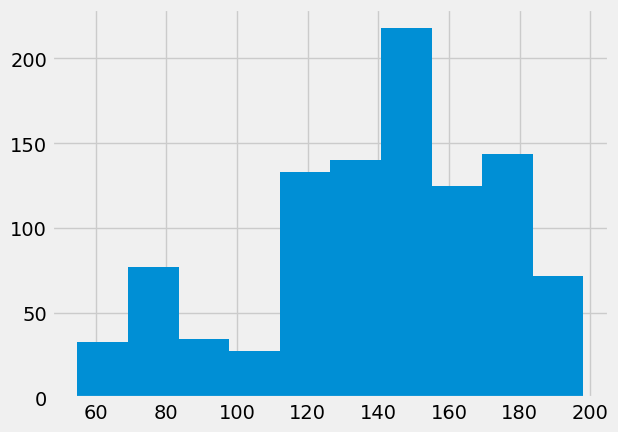

In [9]:
df["FutureClose"].hist()

Visualization

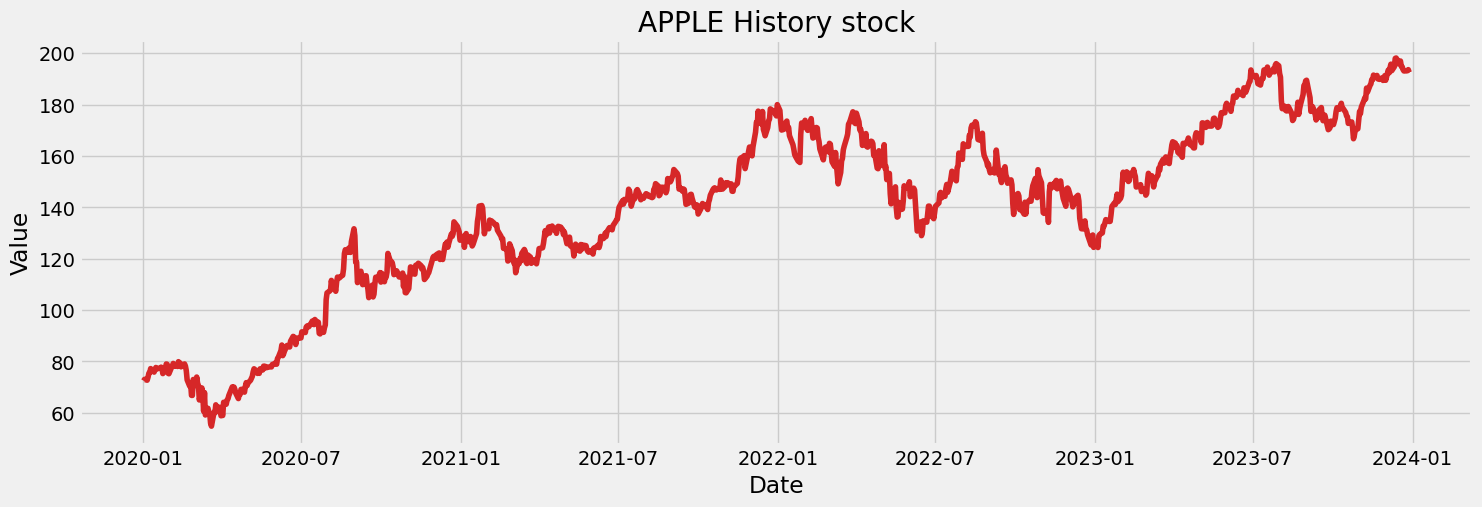

In [10]:
x = df.index
y = df['FutureClose']
def df_plot(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
df_plot(x , y, title="APPLE History stock", xlabel='Date', ylabel='Value')

Variable Correlations with Target

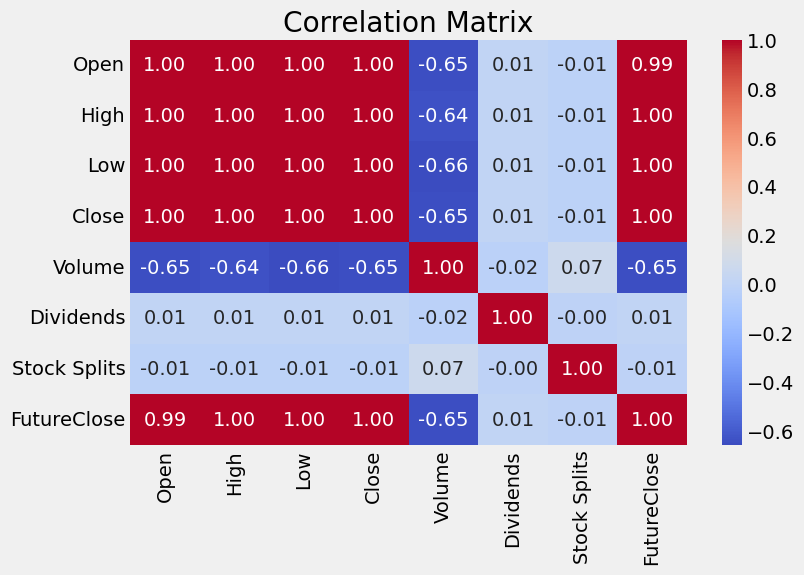

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Data Processing and scaling

The variables Open, Close, High, and Low are highly correlated with each other and also correlate with the target variable; therefore, we will retain one of them. The variables Dividends and Stock are not correlated with the target class; hence, we will delete them.

In [12]:
df.drop(columns=['Dividends','Stock Splits', 'High', 'Low', 'Open'], inplace=True)

In [13]:
df.head()

,Close,Volume,FutureClose
Date,,,
2020-01-02 00:00:00-05:00,73.152641,135480400,72.441467
2020-01-03 00:00:00-05:00,72.441467,146322800,73.018700
2020-01-06 00:00:00-05:00,73.018700,118387200,72.675270
2020-01-07 00:00:00-05:00,72.675270,108872000,73.844330
2020-01-08 00:00:00-05:00,73.844330,132079200,75.412849


from matplotlib import pyplot as plt
_df_0['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Volume'].plot(kind='hist', bins=20, title='Volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['FutureClose'].plot(kind='hist', bins=20, title='FutureClose')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Close', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Volume', y='FutureClose', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Volume'].plot(kind='line', figsize=(8, 4), title='Volume')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['FutureClose'].plot(kind='line', figsize=(8, 4), title='FutureClose')
plt.gca().spines[['top', 'right']].set_visible(False)

Features and Target classification

In [16]:
X = df[['Close', 'Volume']]
y = df['FutureClose']

Data Split

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state = 0)

In [17]:
df["Date"] = pd.to_datetime(df.index)

In [18]:
df.head()

,Close,Volume,FutureClose,Date
Date,,,,
2020-01-02 00:00:00-05:00,73.152641,135480400,72.441467,2020-01-02 00:00:00-05:00
2020-01-03 00:00:00-05:00,72.441467,146322800,73.018700,2020-01-03 00:00:00-05:00
2020-01-06 00:00:00-05:00,73.018700,118387200,72.675270,2020-01-06 00:00:00-05:00
2020-01-07 00:00:00-05:00,72.675270,108872000,73.844330,2020-01-07 00:00:00-05:00
2020-01-08 00:00:00-05:00,73.844330,132079200,75.412849,2020-01-08 00:00:00-05:00


In [19]:
test_end_date = df['Date'].max()
test_start_date = test_end_date - timedelta(days=59)

# Split based on the year 2023
#train_data = df[df['Date'].dt.year < 2023]
#test_data = df[df['Date'].dt.year == 2023]

# Split the data into training and testing sets
train_data = df[df['Date'] < test_start_date]
test_data = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

# Separate features (X) and target variable (y) for both training and testing sets
X_train = train_data[['Close', 'Volume']]
y_train = train_data['FutureClose']

X_test = test_data[['Close', 'Volume']]
y_test = test_data['FutureClose']

In [20]:
y_test.head()

Date
2023-10-31 00:00:00-04:00    173.741104
2023-11-01 00:00:00-04:00    177.336380
2023-11-02 00:00:00-04:00    176.417572
2023-11-03 00:00:00-04:00    178.994186
2023-11-06 00:00:00-05:00    181.580780
Name: FutureClose, dtype: float64

In [21]:
# Checking
print(df.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1005, 4)
(964, 2)
(41, 2)
(964,)
(41,)


#### Establish Benchmarks

#### Metrics
For this regression task, we will use two standard metrics:

- Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values
- Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

In [22]:
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    return mae, rmse

#### Naive Baseline

In a regression task, a straightforward and naive baseline involves predicting the median value from the training set for all testing cases. If our machine learning model fails to outperform this simple baseline, it may indicate the need for exploring alternative approaches.

In [23]:
model_name_list = ['Baseline', 'Linear Regression', 'Bayesian Regression']
benchmarks = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)

In [24]:
# Calculate the median value from the training set
median_value = np.median(y_train)

# Create predictions using the median value for all testing cases
baseline_predictions = np.full_like(y_test, fill_value=median_value)
mae, rmse = evaluate_predictions(baseline_predictions, y_test)

benchmarks.loc['Baseline', :] = [mae, rmse]

print(f"Median Baseline MAE:  {mae:.2f}")
print(f"Median Baseline RMSE: {rmse:.2f}")

Median Baseline MAE:  46.52
Median Baseline RMSE: 46.89


##### Regression algorithm model implementation

In [25]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [26]:
print("regression coefficient", regression_model.coef_)
print("regression intercept", regression_model.intercept_)

regression coefficient [ 9.93456824e-01 -1.71036950e-09]
regression intercept 1.1715112707469473


##### Prediction

In [27]:
X_test.head()

,Close,Volume
Date,,
2023-10-31 00:00:00-04:00,170.545319,44846000
2023-11-01 00:00:00-04:00,173.741104,56934900
2023-11-02 00:00:00-04:00,177.336380,77334800
2023-11-03 00:00:00-04:00,176.417572,79763700
2023-11-06 00:00:00-05:00,178.994186,63841300


In [28]:
predictions = regression_model.predict(X_test)
df2 = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': predictions})
df2.head()

,Actual_Price,Predicted_Price
Date,,
2023-10-31 00:00:00-04:00,173.741104,170.524219
2023-11-01 00:00:00-04:00,177.336380,173.678417
2023-11-02 00:00:00-04:00,176.417572,177.215277
2023-11-03 00:00:00-04:00,178.994186,176.298327
2023-11-06 00:00:00-05:00,181.580780,178.885315


In [29]:
# Metrics
mae = np.mean(abs(predictions - y_test))
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))

# Insert results into the dataframe
benchmarks.loc["Linear Regression", :] = [mae, rmse]

In [31]:
benchmarks

,mae,rmse
Baseline,46.516032,46.892033
Linear Regression,1.476316,1.851433
Bayesian Regression,NaN,NaN


In [51]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2023-10-31 00:00:00-04:00 to 2023-12-28 00:00:00-05:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Actual_Price     41 non-null     float64
 1   Predicted_Price  41 non-null     float64
 2   Bayes_Price      41 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


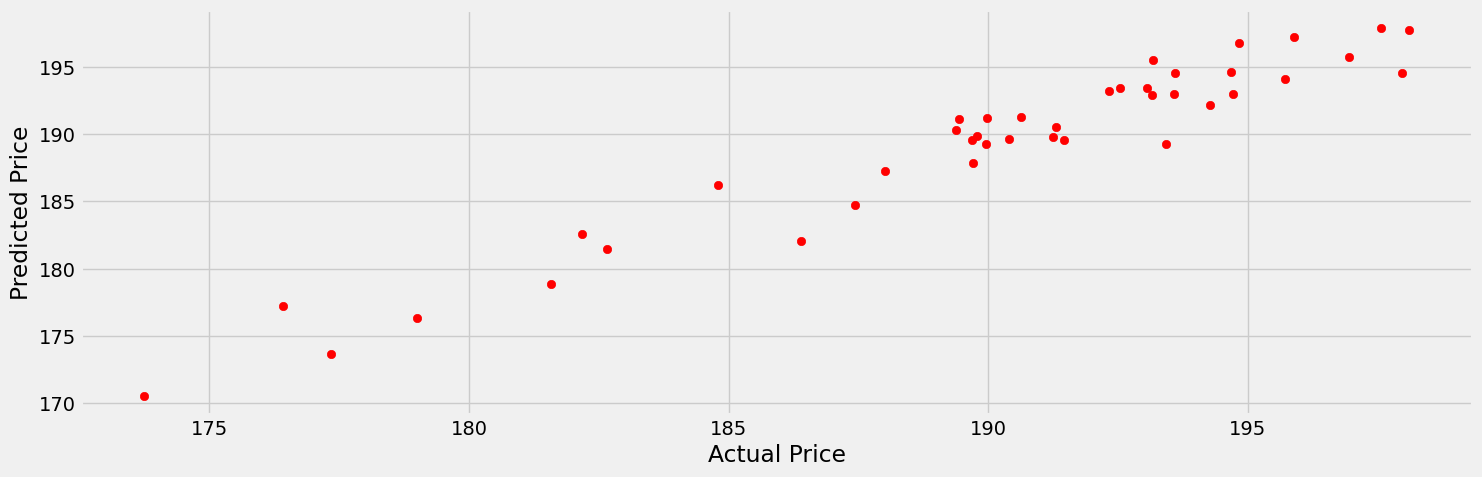

In [32]:
plt.figure(figsize=(16,5), dpi=100)
plt.scatter(df2.Actual_Price, df2.Predicted_Price,  color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

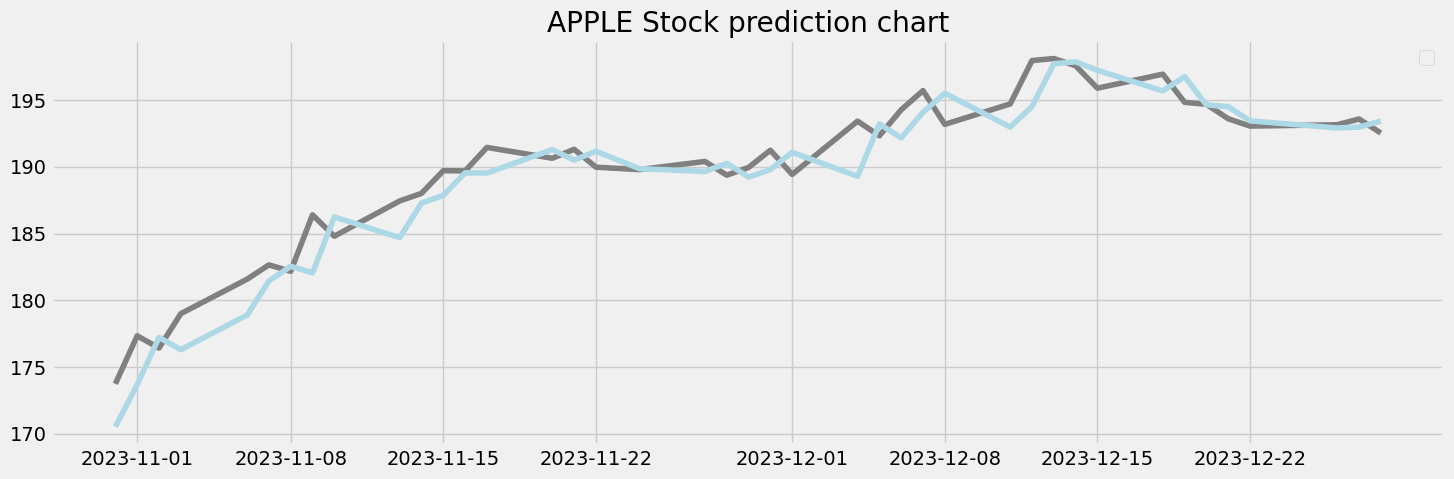

In [33]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df2.Actual_Price, color='gray')
plt.plot(df2.Predicted_Price, color='lightblue')
plt.title("APPLE Stock prediction chart")
plt.legend();

## Bayesian Regression

Let build the bayesian model using normal distribution for the data likelihood. Then, we let a Markov Chain Monte.

In [ ]:
# Separate features (X) and target variable (y) for both training and testing sets
X_train = train_data[['Close', 'Volume']]
y_train = train_data['FutureClose']

X_test = test_data[['Close', 'Volume']]
y_test = test_data['FutureClose']

In [34]:
df.head()

,Close,Volume,FutureClose,Date
Date,,,,
2020-01-02 00:00:00-05:00,73.152657,135480400,72.441467,2020-01-02 00:00:00-05:00
2020-01-03 00:00:00-05:00,72.441467,146322800,73.018707,2020-01-03 00:00:00-05:00
2020-01-06 00:00:00-05:00,73.018707,118387200,72.675293,2020-01-06 00:00:00-05:00
2020-01-07 00:00:00-05:00,72.675293,108872000,73.844360,2020-01-07 00:00:00-05:00
2020-01-08 00:00:00-05:00,73.844360,132079200,75.412865,2020-01-08 00:00:00-05:00


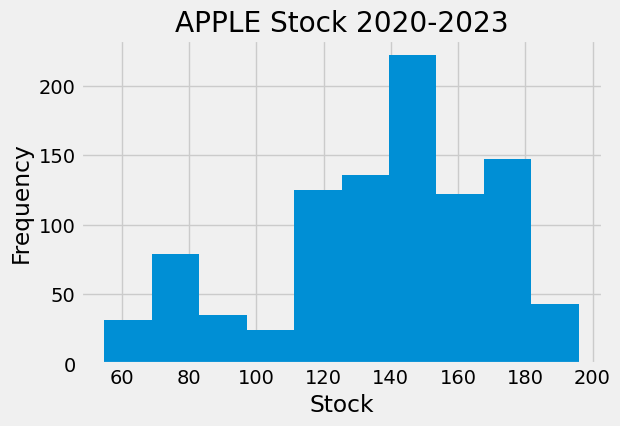

In [35]:
plt.hist(y_train)
plt.xlabel('Stock')
plt.ylabel('Frequency')
plt.title('APPLE Stock 2020-2023')
plt.gcf().set_size_inches(6, 4)
plt.show()

Model

In [36]:
# T-DIST_LIKELIHOOD MODEL

with pm.Model() as bayesian_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + (beta0 * X_train.Close.values) + (beta1 * X_train.Volume.values)

    # Likelihood function
    likelihood = pm.StudentT('FuturePrice', nu=3, mu=mu, sigma=sigma, observed=y_train)

In [ ]:
# GUMBEL_LIKELIHOOD MODEL

with pm.Model() as bayesian_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + (beta0 * X_train.Close.values) + (beta1 * X_train.Volume.values)

    # Likelihood function
    likelihood = pm.Gumbel('FuturePrice', mu=mu, beta=sigma, observed=y_train)

In [ ]:
# NORMAL_LIKELIHOOD MODEL

with pm.Model() as bayesian_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + (beta0 * X_train.Close.values) + (beta1 * X_train.Volume.values)
    # pm.math.dot(X, beta)

    # Likelihood function
    likelihood = pm.Normal('FuturePrice', mu=mu, sigma=sigma, observed=y_train)

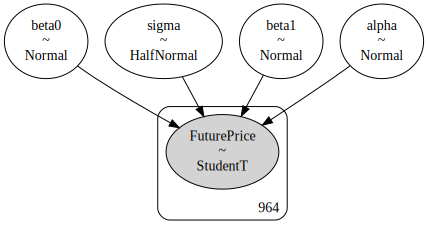

In [37]:
pm.model_to_graphviz(bayesian_model)

In [38]:
with bayesian_model:
    idata = pm.sample(draws=1000, chains=1)

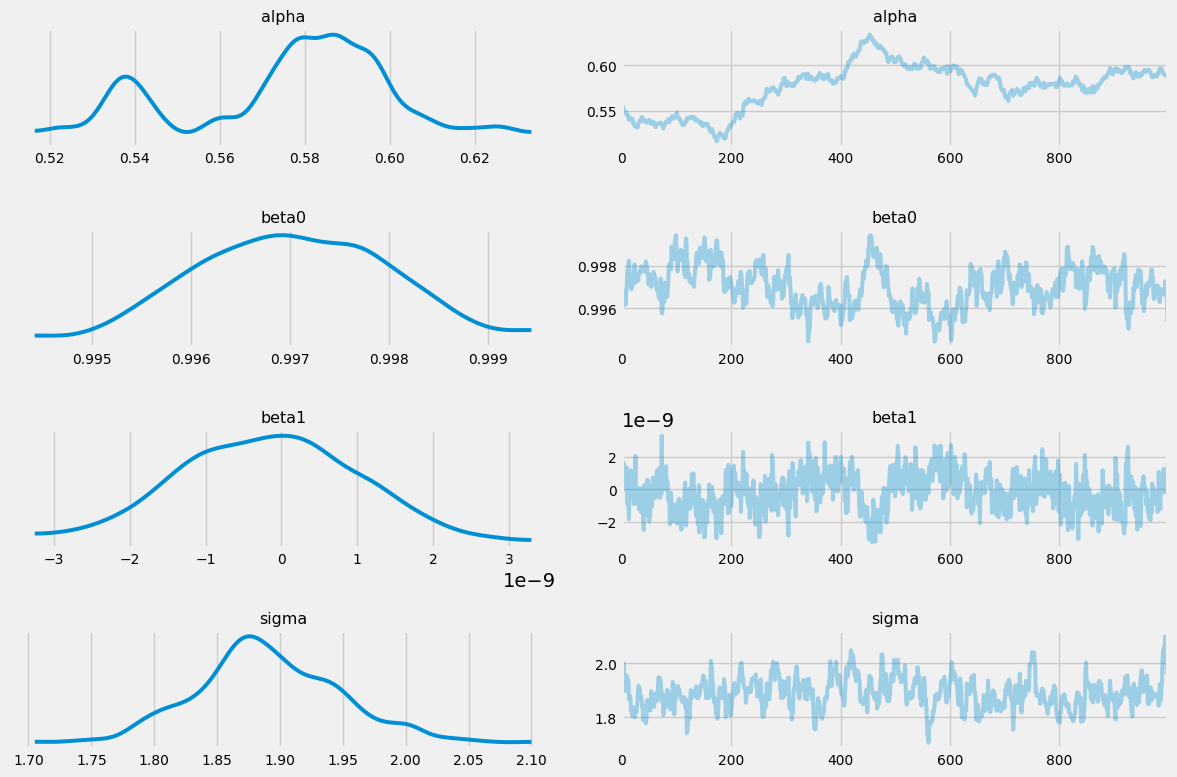

In [40]:
az.plot_trace(idata);
plt.tight_layout()

In [41]:
az.summary(idata, round_to=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.58,0.03,0.52,0.61,0.01,0.01,5.71,11.60,NaN
beta0,1.00,0.00,1.00,1.00,0.00,0.00,15.78,57.42,NaN
beta1,-0.00,0.00,-0.00,0.00,0.00,0.00,48.41,188.23,NaN
sigma,1.89,0.06,1.79,2.01,0.01,0.00,87.66,178.61,NaN


In [42]:
alpha = az.summary(idata, round_to=3)["mean"]["alpha"]
beta0 = az.summary(idata, round_to=3)["mean"]["beta0"]
beta1 = az.summary(idata, round_to=3)["mean"]["beta1"]

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


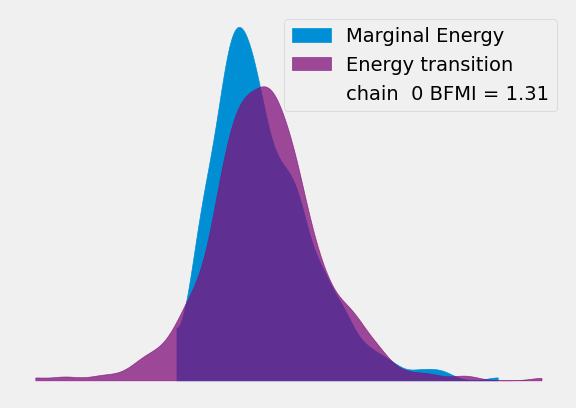

In [43]:
az.plot_energy(idata);

Intervale de confiance

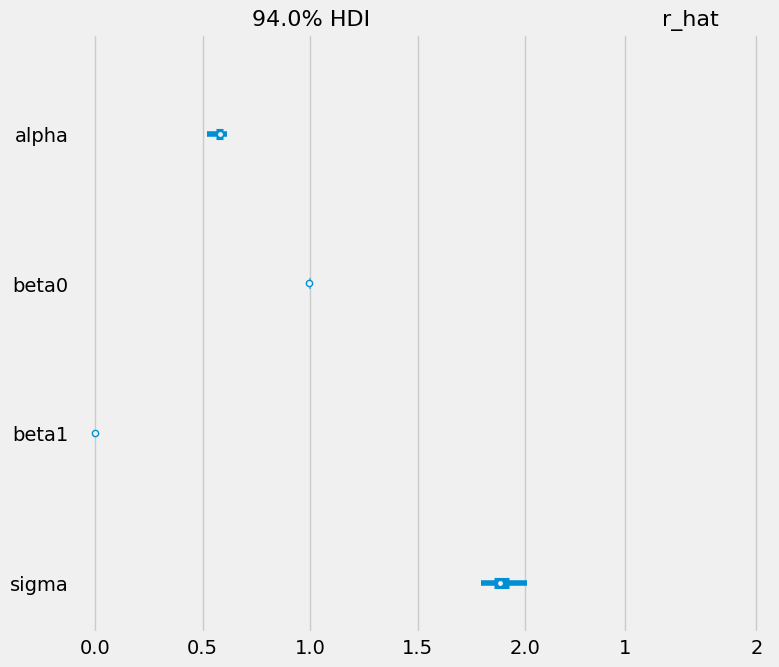

In [44]:
az.plot_forest(idata, combined=True, r_hat=True);

In [45]:
alpha, beta0, beta1

(0.576, 0.997, -0.0)

In [ ]:
# DONT RUN
simple_return = alpha + (beta0 * X_test.Close.values) + (beta1 * X_test.Volume.values)
#predictions_bayes = (1 + simple_return) * X_test.Close.values
#y_test = test_data['FutureClose']

df2 = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': predictions, 'Bayes_Price': predictions_bayes})
df2.head()

,Actual_Price,Predicted_Price,Bayes_Price
Date,,,
2023-01-03 00:00:00-05:00,125.657639,124.472411,114.891174
2023-01-04 00:00:00-05:00,124.325081,125.766331,116.398590
2023-01-05 00:00:00-05:00,128.899521,124.450435,114.832881
2023-01-06 00:00:00-05:00,129.426559,128.986308,120.237350
2023-01-09 00:00:00-05:00,130.003342,129.524505,120.865396


In [46]:
predictions_bayes = alpha + (beta0 * X_test.Close.values) + (beta1 * X_test.Volume.values)
df2 = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': predictions, 'Bayes_Price': predictions_bayes})
df2.head()

,Actual_Price,Predicted_Price,Bayes_Price
Date,,,
2023-10-31 00:00:00-04:00,173.741104,170.524218,170.609683
2023-11-01 00:00:00-04:00,177.336380,173.678417,173.795881
2023-11-02 00:00:00-04:00,176.417572,177.215278,177.380371
2023-11-03 00:00:00-04:00,178.994186,176.298327,176.464319
2023-11-06 00:00:00-05:00,181.580780,178.885315,179.033204


In [47]:
# Metrics
mae = np.mean(abs(predictions_bayes - y_test))
rmse = np.sqrt(np.mean((predictions_bayes - y_test) ** 2))

# Insert results into the dataframe
benchmarks.loc["Bayesian Regression", :] = [mae, rmse]

In [48]:
benchmarks

,mae,rmse
Baseline,46.516032,46.892033
Linear Regression,1.476316,1.851433
Bayesian Regression,1.45526,1.808408


In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2023-10-31 00:00:00-04:00 to 2023-12-28 00:00:00-05:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Actual_Price     41 non-null     float64
 1   Predicted_Price  41 non-null     float64
 2   Bayes_Price      41 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


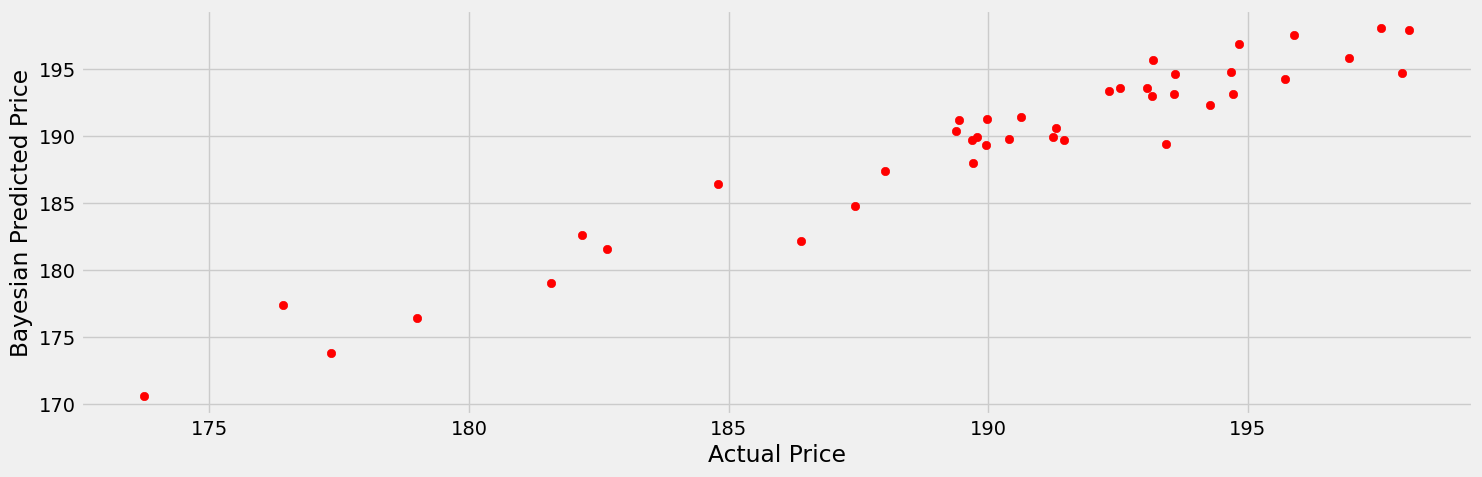

In [52]:
plt.figure(figsize=(16,5), dpi=100)
plt.scatter(df2.Actual_Price, df2.Bayes_Price,  color='red')
plt.xlabel("Actual Price")
plt.ylabel("Bayesian Predicted Price")
plt.show()

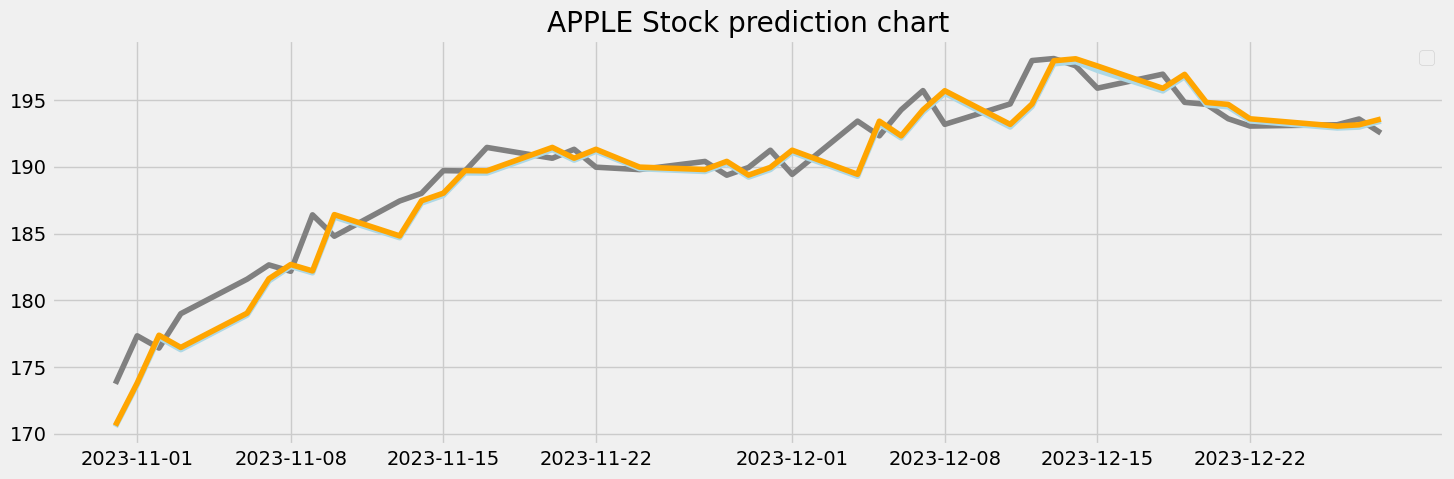

In [53]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df2.Actual_Price, color='gray')
plt.plot(df2.Predicted_Price, color='lightblue')
plt.plot(df2.Bayes_Price, color='orange')
plt.title("APPLE Stock prediction chart")
plt.legend();